# Decoding Neural Signals with Hybrid Quantum LSTMs

## Introduction

Inspired by advances in neuroscience and related recording technology, the [Neural Latents Benchmark Challenge](https://neurallatents.github.io/) (NLB) released datasets and a Machine Learning Challenge for the Neuroscience community in 2021. 

In this project, I continue work on the NLB dataset by exploring the intersection between Hybrid Quantum ML and Neural Decoding. In particular, I use Quantum LSTM architecture to predict the hand movement of a macaque monkey, given electrophysiological measurements recorded using intracortical microelectrode arrays. 

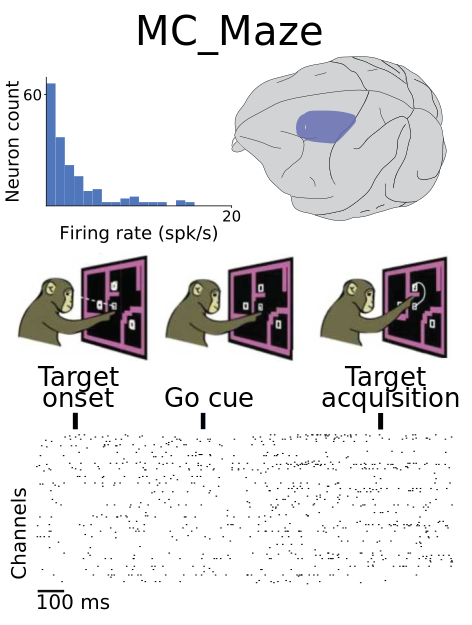

In [1]:
from IPython.display import display, Image
display(Image(filename="images/maze_fig1.png", embed=True))

## About the Data

The dataset was provided by Krishna Shenoy, Mark Churchland, and Matt Kaufman from Stanford University, and you can learn more about the task design, data collection, and their analyses of the data in a number of papers, including [this](https://pubmed.ncbi.nlm.nih.gov/21040842/) (Churchland et al. 2010). 

Neural Latents Benchmark ([NLB](https://neurallatents.github.io/))<a name="citenlb"></a>[<sup>1</sup>](#footnotenlb)

This project is concerned exclusively with the [MC_Maze](https://neurallatents.github.io/datasets#mcmaze) dataset. NLB provided a demo of this dataset [here](https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_maze.ipynb). In short, a monkey with a brain implant views a screen, and is instructed to move a digital cursor through a simple maze. Each electrode on the implant records neural activity, measured by proximate spikes in voltage. These spikes in activity can be used to predict the actual movement that the monkey performed.

<a name="footnotenlb"></a>[1.](#citenlb) *Neural Latents Benchmark '21: Evaluating latent variable models of neural population activity*, Felix Pei and Joel Ye and David M. Zoltowski and Anqi Wu and Raeed H. Chowdhury and Hansem Sohn and Joseph E. O'Doherty and Krishna V. Shenoy and Matthew T. Kaufman and Mark Churchland and Mehrdad Jazayeri and Lee E. Miller and Jonathan Pillow and Il Memming Park and Eva L. Dyer and Chethan Pandarinath

### Download Data if necessary

In [2]:
# # Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000128
# # In the above, replace the dandiset ID with the one you want to download.
# # For convenience, I have included the smallest version of the dataset in the data folder of this repo

### Imports & Load Data

In [3]:
# Standard imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

# modelling
from torch.utils.data import DataLoader
import torch
from TSModels import SequenceDataset, ShallowRegressionLSTM, QLSTM, QShallowRegressionLSTM

# NLB specifics
from nlb_tools.nwb_interface import NWBDataset

#eval
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [4]:
dataset_name = "mc_maze_small" 

datanames = {
    'mc_maze' : '000128',
    'mc_maze_large' : '000138',
    'mc_maze_small' : '000140',
}
fp = f"data/{datanames[dataset_name]}/sub-Jenkins/"

In [5]:
dataset = NWBDataset(fp, 
    "*train" , split_heldout=False
    )
dataset.data.shape

(293666, 150)

## Preprocessing

The raw data measures neural spikes recorded each millisecond, but NLB suggests re-binning the data into either 5ms or 20ms bins. Here, we'll use 20ms bins. 

In [6]:
print(dataset.bin_width)
dataset.resample(20)
print(dataset.bin_width)

1
20


Additionally, we must consider the delay between neural activation, and the actual physical reaction of the monkey's hand. NLB recommends an 80ms delay, such that if a neural spike indicates hand movement, we'd expect to see the neural activity 80ms prior to when the actual movement is observed. 

In [7]:
# here, we offset our inputs and target variables with an 80ms difference
# Extract neural data and lagged hand velocity
baseline_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-130, 370))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450))

# Define X and Y from these dataframes, temporarily including trial id on X
xcols = [x for x in baseline_trial_data.columns if x[0] == 'spikes']
X = baseline_trial_data[xcols+[('trial_id','')]].copy()
print(f"X shape: {X.shape}")

Y = lagged_trial_data[[('hand_vel','x'),('hand_vel','y')]].copy()
print(f"Y shape: {Y.shape}")

X shape: (2500, 143)
Y shape: (2500, 2)


Train/Test Split

In [8]:
test_pct = .3
cutoff = len(X) * (1 - test_pct)
cutoff = int(cutoff)

X_train, X_test = X[:cutoff].copy(), X[cutoff:].copy()
Y_train, Y_test = Y[:cutoff].copy(), Y[cutoff:].copy()

To validate that this split is valid, we ensure that no specific trial has readings on both train and test. Each trial should be exclusively in one or the other: 

In [9]:
# should be an empty set
set(X_train['trial_id']).intersection(set(X_test['trial_id']))

set()

In [10]:
#now we can safely drop the trial id
X_train.drop(('trial_id',''), axis=1, inplace=True)
X_test.drop(('trial_id',''), axis=1, inplace=True)

In [11]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1750, 142), (750, 142), (1750, 2), (750, 2))

In [12]:
# flatten the column indices to merge into cohesive train/test dataframes
Y_train.columns = ['hand_vel_x', 'hand_vel_y']
Y_test.columns = ['hand_vel_x', 'hand_vel_y']
X_train.columns = [x[1] for x in X_train.columns]
X_test.columns = [x[1] for x in X_test.columns]

traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)
traindf.shape, testdf.shape

((1750, 144), (750, 144))

# Modelling Helper Functions

Generic Training / Predicting functions that can be used for both the QLSTM model and the Classical LSTM benchmark.

In [13]:
def train_model(data_loader, model, loss_function, optimizer, verbose=False):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    if verbose:
        print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, verbose=False):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    if verbose:
        print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# Modelling -- Classical LSTM

Training: For simplicity I will focus on predicting just the X-dimension

In [14]:
torch.manual_seed(101)
batch_size = 1
sequence_length = 4

target = 'hand_vel_x'
features = [x for x in traindf.columns if x not in ('hand_vel_x', 'hand_vel_y')]

train_dataset = SequenceDataset(
    traindf,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    testdf,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 4, 142])
Target shape: torch.Size([1])


### Parameters

Parameters are chosen to be equivalent to what is used in the QLSTM model later in this notebook, to provide a fair comparison. The one exception is Learning Rate, which will be explained in the Comparison section at the bottom.

In [16]:
learning_rate = 0.0005
num_hidden_units = 32
epochs = 20
verbose = False

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
classical_loss_train = []
classical_loss_test = []
if verbose:
    print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)

classical_loss_test.append(test_loss)

for ix_epoch in range(epochs):
    if verbose:
        print(f"\nEpoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, verbose=verbose)
    test_loss = test_model(test_loader, model, loss_function, verbose=verbose)
    
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

In [18]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = ("Model forecast",'')
traindf[ystar_col] = predict(train_eval_loader, model).numpy()
testdf[ystar_col] = predict(test_loader, model).numpy()



In [19]:
df_out = pd.concat((traindf, testdf))[[target, ystar_col]]

/Users/gregcondit/miniconda3/envs/qenv/lib/python3.10/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


### Evaluating the Classical Model

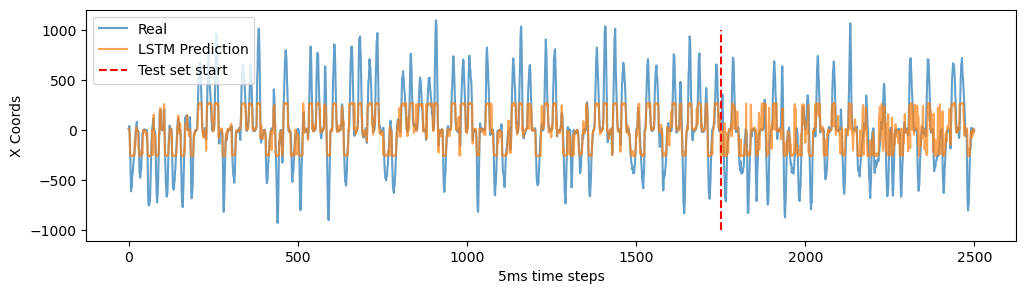

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(range(len(df_out)), df_out[target], label = "Real", alpha = .7)
plt.plot(range(len(df_out)), df_out[ystar_col], label = "LSTM Prediction", alpha = .7)
plt.ylabel('X Coords')
plt.xlabel('5ms time steps')
plt.vlines(len(df_out) * (1 - test_pct), ymin = -1000, ymax = 1000, label = "Test set start", linestyles = "dashed",
          colors = "red")
plt.legend()
plt.show()

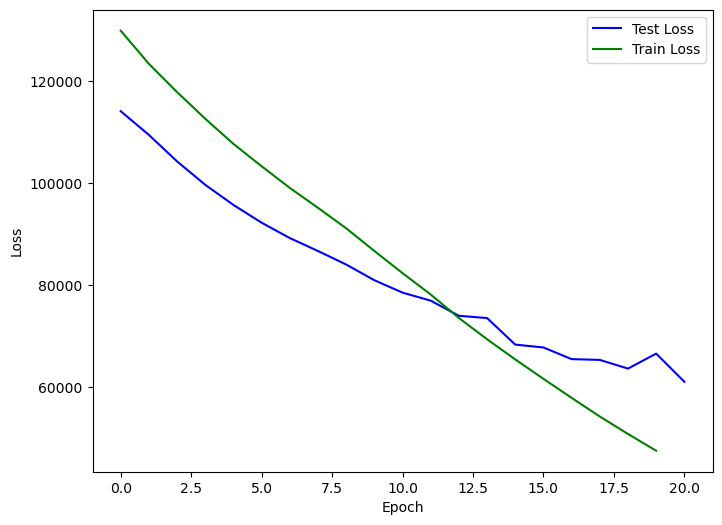

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(classical_loss_test)), classical_loss_test, color = "blue")
plt.plot(range(len(classical_loss_train)), classical_loss_train, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Test Loss", "Train Loss"])
plt.show()

In [22]:
r2_classical = r2_score(testdf[target], testdf[ystar_col])
print(f"R2: {round(r2_classical,2)}")


R2: 0.45


# Modelling -- Quantum LSTM

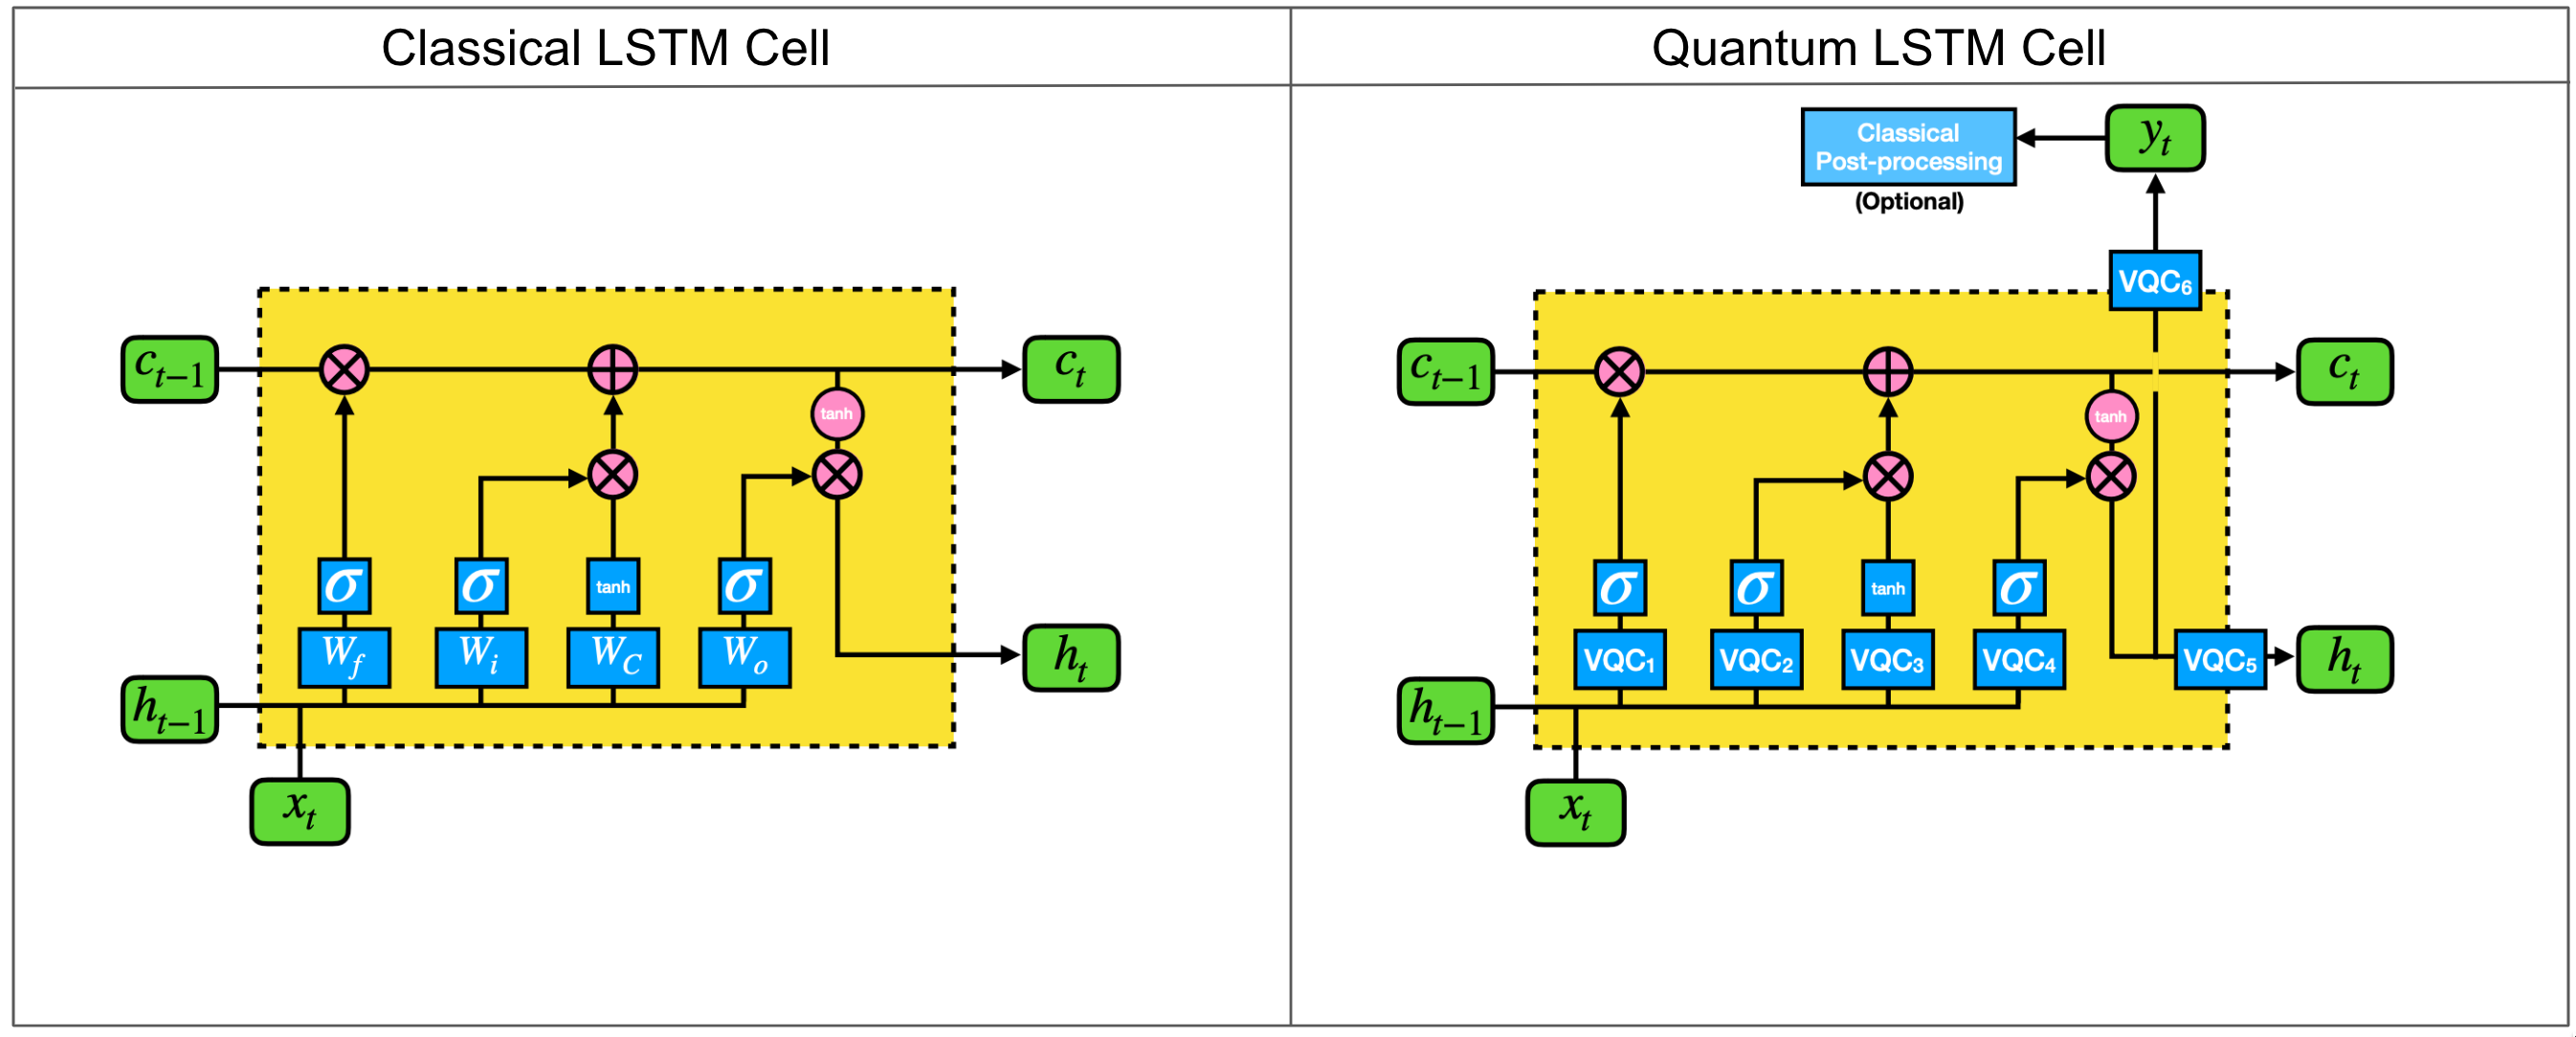

In [23]:
display(Image(filename='images/LSTM-diagram.png'))

*Image credit to Samuel Yen-Chi Chen, Shinjae Yoo, Yao-Lung L. Fang (https://arxiv.org/abs/2009.01783)*

As seen in the above diagram, in a Quantum LSTM, the tunable weight matrices are replaced by Variational Quantum Circuits (VQC). VQCs are quantum circuits with learnable rotation parameters. VQCs are small in circuit size, and qubit errors can be corrected during optimization, making them viable learners in the NISQ era. You can learn more about VQCs [here](https://pennylane.ai/qml/glossary/variational_circuit.html#variational-circuits). 

In [24]:
# Define X and Y from these dataframes, temporarily including trial id on X
xcols = [x for x in baseline_trial_data.columns if x[0] == 'spikes']
Xq = baseline_trial_data[xcols+[('trial_id','')]].copy()
print(f"X shape: {Xq.shape}")

Yq = lagged_trial_data[[('hand_vel','x'),('hand_vel','y')]].copy()
print(f"Y shape: {Yq.shape}")

X shape: (2500, 143)
Y shape: (2500, 2)


In [25]:
test_pct = .3
cutoff = len(Xq) * (1 - test_pct)
cutoff = int(cutoff)

X_trainq, X_testq = Xq[:cutoff].copy(), Xq[cutoff:].copy()
Y_trainq, Y_testq = Yq[:cutoff].copy(), Yq[cutoff:].copy()

To validate that this split is valid, we ensure that no specific trial has readings on both train and test. Each trial should be exclusively in one or the other: 

In [26]:
# should be an empty set
set(X_trainq['trial_id']).intersection(set(X_testq['trial_id']))

set()

In [27]:
#now we can safely drop the trial id
X_trainq.drop(('trial_id',''), axis=1, inplace=True)
X_testq.drop(('trial_id',''), axis=1, inplace=True)

In [28]:
# flatten the column indices to merge into cohesive train/test dataframes
Y_trainq.columns = ['hand_vel_x', 'hand_vel_y']
Y_testq.columns = ['hand_vel_x', 'hand_vel_y']
X_trainq.columns = [x[1] for x in X_trainq.columns]
X_testq.columns = [x[1] for x in X_testq.columns]

traindfq = pd.merge(X_trainq, Y_trainq, left_index=True, right_index=True)
testdfq = pd.merge(X_testq, Y_testq, left_index=True, right_index=True)
traindfq.shape, testdfq.shape

((1750, 144), (750, 144))

In [29]:
torch.manual_seed(101)

batch_size = 1
# we'll start by looking back 4 time steps, which is 20 ms
sequence_length = 4

In [30]:
target = 'hand_vel_x'
features = [x for x in traindfq.columns if x not in ('hand_vel_x', 'hand_vel_y')]


train_datasetq = SequenceDataset(
    traindfq,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_datasetq = SequenceDataset(
    testdfq,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [31]:
train_loaderq = DataLoader(train_datasetq, batch_size=batch_size, shuffle=True)
test_loaderq = DataLoader(test_datasetq, batch_size=batch_size, shuffle=False)

X_, y_ = next(iter(train_loaderq))

print("Features shape:", X_.shape)
print("Target shape:", y_.shape)

Features shape: torch.Size([1, 4, 142])
Target shape: torch.Size([1])


In [32]:
learning_rate = 0.05 # with fewer parameters, we can afford a higher learning rate
num_hidden_units = 32
epochs = 20
verbose = False


Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [33]:
quantum_loss_train = []
quantum_loss_test = []
if verbose:
    print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loaderq, Qmodel, loss_function)
end = time.time()
if verbose:
    print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    if verbose:
        print(f"\nEpoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loaderq, Qmodel, loss_function, optimizer=optimizer, verbose=verbose)
    test_loss = test_model(test_loaderq, Qmodel, loss_function, verbose=verbose)
    end = time.time()
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

In [34]:
train_eval_loaderq = DataLoader(train_datasetq, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
traindfq[ystar_col_Q] = predict(train_eval_loaderq, Qmodel).numpy()
testdfq[ystar_col_Q] = predict(test_loaderq, Qmodel).numpy()

In [35]:
df_out_Q = pd.concat((traindfq, testdfq))[[target, ystar_col_Q]]

print(df_out_Q.head())

   hand_vel_x  Model forecast
0    9.749481      -55.049793
1   31.199101      -40.008533
2   41.501937      -61.710861
3  -41.959898     -104.143517
4 -172.545916     -173.528656


### Evaluating the Hybrid Model

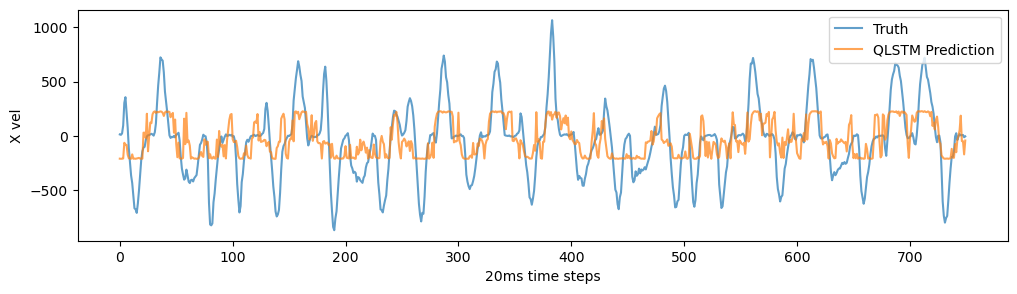

In [36]:
plt.figure(figsize=(12, 3))
plt.plot(range(len(testdfq)), testdfq[target], label = "Truth", alpha = .7)
plt.plot(range(len(testdfq)), testdfq[ystar_col_Q], label = "QLSTM Prediction", alpha = .7)
plt.ylabel('X vel')
plt.xlabel('20ms time steps')
plt.legend()
plt.show()

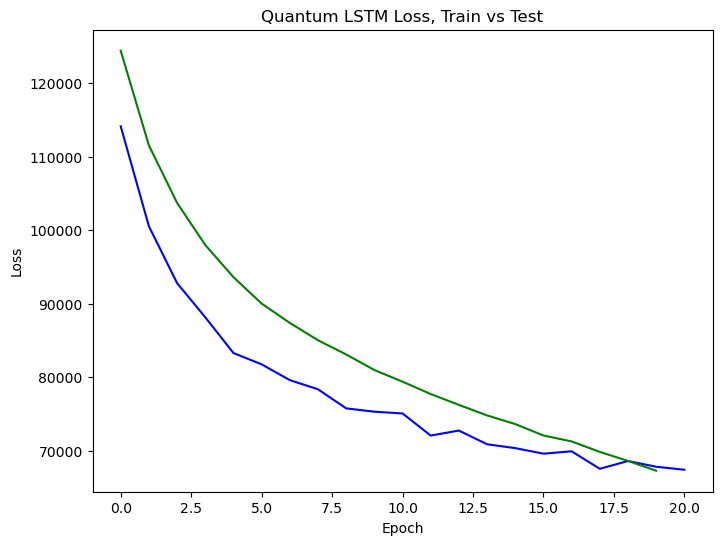

In [37]:
plt.figure(figsize=(8, 6))
plt.title("Quantum LSTM Loss, Train vs Test")
plt.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
plt.plot(range(len(quantum_loss_train)), quantum_loss_train, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [38]:
r2q = r2_score(testdfq[target], testdfq[ystar_col_Q])
print(f"R2: {round(r2q,2)}")


R2: 0.39


# Comparing the Classical & Hybrid Models

Overall, the Classical model achieved better performance with these shallow parameters:

In [39]:
print(f"Classical LSTM R2: {round(r2_classical,2)}")
print(f"Quantum LSTM R2: {round(r2q,2)}")


Classical LSTM R2: 0.45
Quantum LSTM R2: 0.39


Notably, 

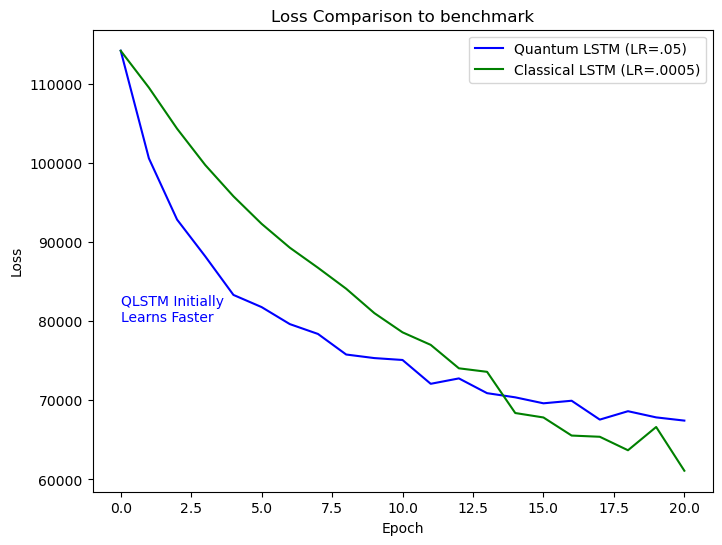

In [58]:

plt.figure(figsize=(8, 6))
plt.title("Loss Comparison to benchmark")
plt.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
plt.plot(range(len(classical_loss_test)), classical_loss_test, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Quantum LSTM (LR=.05)", "Classical LSTM (LR=.0005)"])
#annotate 
plt.annotate("QLSTM Initially \nLearns Faster", xy=(0, 80000), color='blue')
plt.show()

# Discussion: 

## The faster learning can be attributed to a higher learning rate. When the Classical Model was trained with a comparably high learning rate, the loss was erratic and the model did not consistently converge - examples below:

(These were run with the above code and different parameters, then hardcoded to keep this notebook brief)

In [59]:
#Classical Model loss curves with other learning rates
lr05 = [114077.89764236468,
 81481.46817123143,
 64824.328366032365,
 75592.94361737673,
 67493.16275721168,
 74120.20942018824,
 91387.7571801783,
 82135.4177480573,
 76124.06902543447,
 71916.65322440474,
 77824.61300355283,
 70426.41905296233,
 71579.79856309509,
 80511.72863193338,
 72530.33600490689,
 68731.41948357348,
 62613.155898108635,
 65552.73984501898,
 63788.32866379444,
 64997.79340923659,
 62076.921944166505]

lr01 = [114089.75991455058,
 104302.49213293786,
 94183.11011089878,
 87362.95484839873,
 81701.01882844773,
 89619.6525436152,
 85736.38750253886,
 80014.4933178164,
 76311.66707894341,
 88849.10523185834,
 77625.27330133303,
 71979.75752303298,
 74933.6224927617,
 82031.56858988515,
 79954.25477116962,
 74340.79440983337,
 73404.6834018364,
 72768.80780381664,
 71673.95534439145,
 70275.06856616164,
 66454.20482501677]

lr005 = [114156.72710874665,
 101394.0643662035,
 91098.15723306457,
 83859.98755085959,
 86704.83424575948,
 81405.25153698507,
 78425.22077172245,
 79879.98735717706,
 74980.65965048494,
 66245.5454538543,
 62065.78989811788,
 62729.93414617016,
 59625.52091203358,
 57207.59337608584,
 56606.048205472114,
 63012.99953351271,
 60849.067049221754,
 54667.271716989,
 53804.247679290136,
 59218.076716084164,
 57927.989844523705]

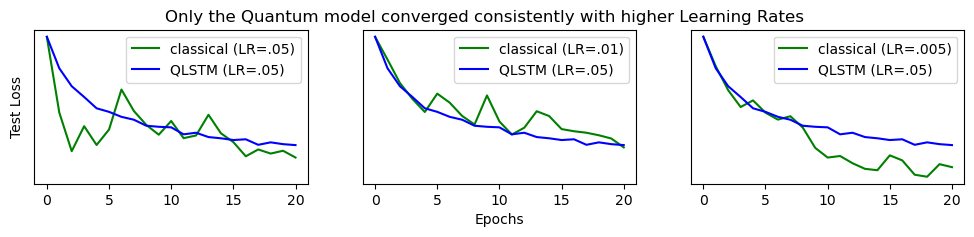

In [60]:
fig = plt.figure(figsize=(12, 2))
fig.suptitle('Only the Quantum model converged consistently with higher Learning Rates', fontsize=12)
ax = fig.add_subplot(1, 3, 1)
ax.plot(range(len(lr05)), lr05, color='green')
ax.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
ax.set_yticks([])
ax.set_ylabel('Test Loss')
ax.legend(['classical (LR=.05)', 'QLSTM (LR=.05)'])

ax2 = fig.add_subplot(1, 3, 2, sharey=ax)
ax2.plot(range(len(lr01)), lr01, color='green')
ax2.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
ax2.set_xlabel('Epochs')
ax2.set_yticks([])
ax2.legend(['classical (LR=.01)', 'QLSTM (LR=.05)'])

ax3 = fig.add_subplot(1, 3, 3, sharey=ax)
ax3.plot(range(len(lr005)), lr005, color='green')
ax3.plot(range(len(quantum_loss_test)), quantum_loss_test, color = "blue")
ax3.set_yticks([])
ax3.legend(['classical (LR=.005)', 'QLSTM (LR=.05)'])
plt.show()


